This tutorial guides you on how to train a word embedding from scratch and visualize the embeddings using the Embedding Projector.

In [0]:
!pip install -q tf-nightly tfds-nightly

In [43]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import io

tfds.disable_progress_bar()

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200211
GPU is available.


# Representing Text as Numbers

The machine learning model takes numbers as inputs. When it comes to the text, the first thing is to convert the text into numbers or to vectorize the text.

## One-hot Encodings

![One-hot Encoding](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1)

from tensorflow.org (2020)

One-hot encoding is inefficient and sparse (most numbers in the vectors are zeros).

## Encode Each Word with a Unique Number

The example of the encoding using this approach is that `The cat is sitting on the car.` is converted to `[6, 2, 3, 5, 4, 6, 1]`.

This approach is efficient and dense, however, it has several downsides.
* The integer-encoding is arbitrary. (it can't show any relationships between words)
* It is hard to interpret the model. **Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.**


## Word Embeddings

Word embeddings provide an efficient and dense representation way to show the relationships between words (similar words have similar vectors). More importantly, the word embedding layer is the byproduct of the training task to a specific purpose. When we train a text model on the final layer, we also train the embedding layer on the previous layers as well. One of the previous layers is the embedding layer. It is common to see word embeddings in 8 dimensions (for a small dataset), up to 1024 dimensions (for a large dataset). However, more dimensions require more datasets to train.

The below is the example. Each word is represented as a 4-dimensional vector of floating values.

![](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1)

Tensorflow.org(2020)

Another concept to think of a word embedding is as `lookup table`.


# Using the Embedding Layer

The embedding layer can be thought of as a lookup table that maps from integer indices (stand for a group of words) to dense vectors. The `input_dim` value is the size of the total words (more specific the word in an encoder). The `output_dim` value is the value that you can experiment with, like the value of `units` in the Dense layer.

In [0]:
# each word is represented as 5-dimensional vector of floating values
embedding_layer = tf.keras.layers.Embedding(input_dim=1000, output_dim=5)

If you pass the integer to an embedding layer, that means lookup the table for the vectors representing the group of integers (or words). If an embedding layer was created, the weight values were also randomly generated. After training, the weight value would be updated that is like the operation of the other layers. The lookup index can't be assigned over 1000 (because the `input_dim` was set to 1000, representing 1000 words).

In [10]:
result = embedding_layer(tf.constant([1, 2, 3, 999]))
result.numpy()

array([[-0.01912798, -0.04000754,  0.01427838,  0.00683967,  0.03734821],
       [-0.00751475,  0.03337619, -0.02842474,  0.04623101,  0.04930094],
       [ 0.04031916,  0.01288435,  0.03955254, -0.04445155, -0.04160825],
       [-0.04484456,  0.01265765,  0.04249953,  0.00079905, -0.04803455]],
      dtype=float32)

For the text or sequence problems, the embedding layer takes 2D tensor of integer, whose shapes are `(sample, sequence_length)`. Each entry is a sequence of integers. The returned tensor has one more axis than the input tensor, the returned tensor's shape becomes `(sample, sequence_length, embedding_output_dim)`. Such output tensor's shape is variant if you try to convert these sequences to a fixed representation for further connections (like dense layers), there are several approaches. For example, you can use RNN, Attention, or a pooling layer (e.g. GlobalAveragePooling1D(), etc.) before passing it to a Dense layer.

In [11]:
inputs = tf.constant([[1, 2, 3], [10, 20, 30]])
print(inputs.shape)

result = embedding_layer(inputs)
print(result.shape)

(2, 3)
(2, 3, 5)


# Learning Embeddings from Scratch

Here we are going to train a sentiment classifier on the IMDB dataset for training an embedding layer from scratch.

In [0]:
(train_data, test_data), info = tfds.load(
  name="imdb_reviews/subwords8k",
  split=(tfds.Split.TRAIN, tfds.Split.TEST),
  with_info=True,
  as_supervised=True)

Before we start training, let's get a decoder and have a look at the vocabulary that the decoder encodes.

In [15]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be of different lengths. Here we use the `padded_batch` method to standardize the sequence length.

In [0]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [19]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  12,  674,   55, ...,    0,    0,    0],
       [  12,  284,   14, ..., 7968, 8044, 7975],
       [  62,    9,    1, ...,    0,    0,    0],
       ...,
       [8002, 7968,  123, ...,    0,    0,    0],
       [ 133, 3114,  333, ...,    0,    0,    0],
       [1284,  405, 1055, ...,    0,    0,    0]])

## Create a Simple Model

Next, we are going to build a model. In this case, it is a `Continuous Bags of Words` style of model. Here we use the `GlobalAveragePooling1D()` method to handle the length variable issue.

In [20]:
embedding_dims = 16

def build_model():
  def _model(inputs):
    embed = tf.keras.layers.Embedding(
      input_dim=encoder.vocab_size, output_dim=embedding_dims)(inputs)
    ave = tf.keras.layers.GlobalAveragePooling1D()(embed)
    x = tf.keras.layers.Dense(units=16, activation='elu')(ave)
    classifier = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
    return classifier

  inputs = tf.keras.Input(shape=(None,))
  classifier = _model(inputs)
  return tf.keras.Model(inputs, classifier)

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


## Compile and Train the Model

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [22]:
history = model.fit(train_batches, 
                    epochs=10, 
                    validation_data=test_batches, 
                    validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 31s 12ms/step - loss: 0.4648 - binary_accuracy: 0.7768 - val_loss: 0.3646 - val_binary_accuracy: 0.8700
Epoch 2/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2678 - binary_accuracy: 0.9007 - val_loss: 0.3491 - val_binary_accuracy: 0.8650
Epoch 3/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2182 - binary_accuracy: 0.9211 - val_loss: 0.3757 - val_binary_accuracy: 0.8650
Epoch 4/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1856 - binary_accuracy: 0.9320 - val_loss: 0.3174 - val_binary_accuracy: 0.8950
Epoch 5/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1689 - binary_accuracy: 0.9416 - val_loss: 0.4844 - val_binary_accuracy: 0.8750
Epoch 6/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1523 - binary_accuracy: 0.9454 - val_loss: 0.5088 - val_binary_accuracy: 0.8600
Epoch 7/10
2500/2500 [=======================

In [24]:
his = history.history
print(his.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


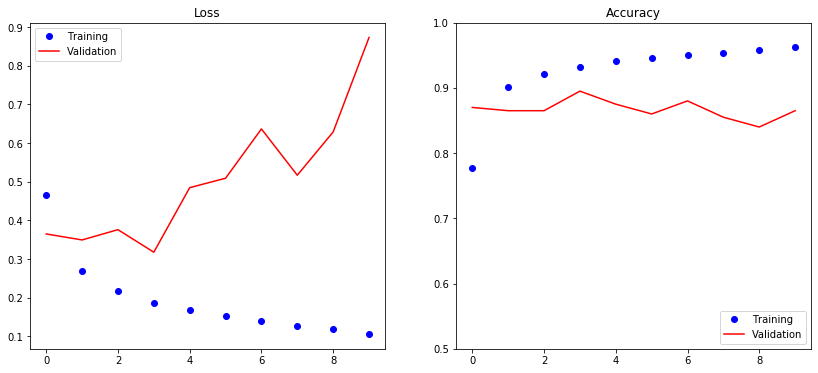

In [27]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(his['loss'], 'bo', label='Training')
plt.plot(his['val_loss'], 'r', label='Validation')
plt.title("Loss")
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(his['binary_accuracy'], 'bo', label='Training')
plt.plot(his['val_binary_accuracy'], 'r', label="Validation")
plt.title('Accuracy')
plt.ylim([0.5, 1.])
plt.legend(loc='lower right')

plt.show()

Let's look at the training history, the overfitting appears.

# Retrieve the Learned Embeddings

In [35]:
embed = model.get_layer('embedding_1')
embed_weights = embed.get_weights()[0]
embed_weights.shape

(8185, 16)

You can also use the index to get the layer.

In [39]:
embed_index = model.layers[1]
embed_index_weights = embed_index.get_weights()[0]
embed_index_weights.shape

(8185, 16)

Next, write the weights to the disk.

In [0]:
encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = embed_weights[num+1]  # skip 0, it is padding
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")

out_v.close()
out_m.close()

Download the weights into the local.

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("vecs.tsv")
  files.download("meta.tsv")

# Visualize the Embeddings

In [0]:
from sklearn.manifold import TSNE
import numpy as np

In [0]:
tsne = TSNE(n_components=2, perplexity=30.0, init='pca', n_iter=5000)
plot_embedding = np.asfarray(embed_weights[:1000, :], dtype='float')
low_dim_embs = tsne.fit_transform(plot_embedding)
labels = encoder.subwords[:1000]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


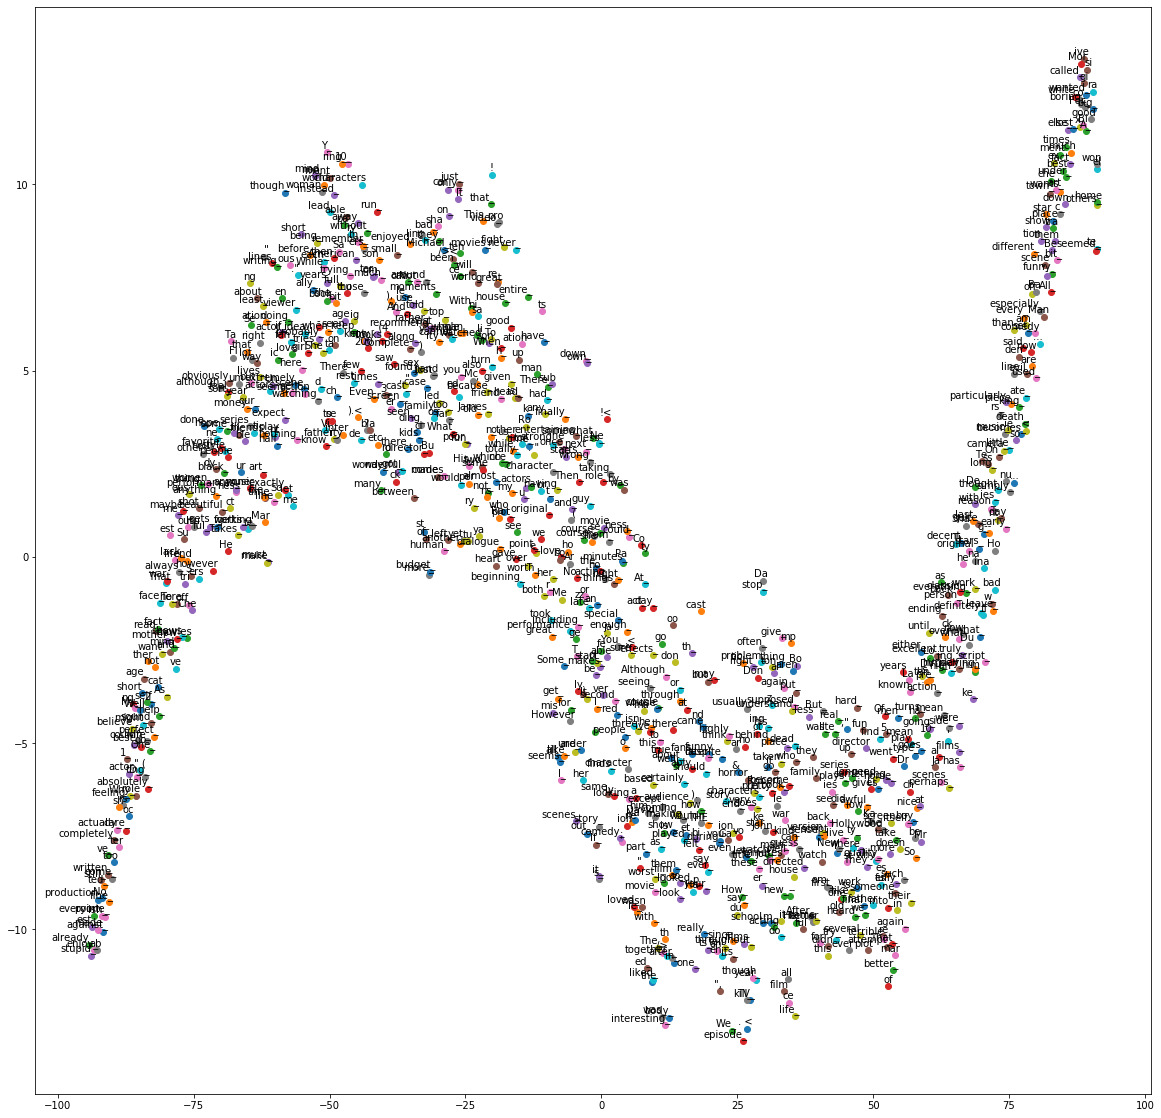

In [56]:
plt.figure(figsize=(20, 20))

for i, label in enumerate(labels):
  x, y = low_dim_embs[i, :]
  plt.scatter(x, y)
  plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
               ha='right', va='bottom')

plt.show()

You can also use the tool [Embedding Projector](http://projector.tensorflow.org/) to visualize the embedding layer.